In [79]:
import numpy as np
from pathlib import Path
from icecream import ic
from scipy.datasets import face
from icecream import ic
import torch

import sys
sys.path.append('../utils')
from joint_names import MOCAP_JOINT_NAMES, SMPL_JOINT_NAMES
import smplx
import pickle

In [80]:
DATAPATH = '/home/siyuan/research/PoseFall/data/processed_data/Trial_100.csv'
VIZ_OUTPUT = '/home/siyuan/research/PoseFall/src/visulization/viz_output'
DATAPATH = Path(DATAPATH)
VIZ_OUTPUT = Path(VIZ_OUTPUT)

# from smplx.joint_names import  JOINT_NAMES, SMPL_JOINT_NAMES 
model_folder= '/home/siyuan/research/PoseFall/data/SMPL_cleaned'
male_model = "/home/siyuan/research/PoseFall/data/SMPL_cleaned/SMPL_MALE.pkl"

In [81]:
import pandas as pd
# read pd from csv and first row is header
df = pd.read_csv(DATAPATH, header=0)
df.iloc[50, :]

frame        5.100000e+01
arm_rot_x   -2.759015e-01
arm_rot_y   -1.569143e-02
arm_rot_z    1.159417e-01
arm_loc_x   -8.257896e-02
                 ...     
L_Hand_y    -1.490116e-08
L_Hand_z    -3.864989e-08
R_Hand_x    -8.428469e-08
R_Hand_y    -1.862645e-08
R_Hand_z     9.778888e-09
Name: 50, Length: 79, dtype: float64

In [89]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


# initialization
def init_human_model():
    human_model = smplx.SMPL(
        model_path = model_folder,
        create_body_pose=True,
        body_pose= None,
        create_betas=True,
        betas=None,
        gender='male',
    )
    output = human_model(return_verts=True, return_full_pose=True)
    return human_model, output
def get_motion_param(frame_num, df = df):
    arm_trans = df.loc[:,['arm_loc_x', 'arm_loc_y', 'arm_loc_z']]
    arm_rot = df.loc[:,['arm_rot_x', 'arm_rot_y', 'arm_rot_z']]
    joint_rot = df.loc[:,'Pelvis_x':'R_Hand_z']
    new_pose = torch.tensor(joint_rot.iloc[frame_num,:], dtype=torch.float32)
    new_pose = new_pose.view(-1, 3)
    bone_rot = new_pose[1:,:]

    # translation
    arm_trans = torch.tensor(arm_trans.iloc[frame_num, :], dtype=torch.float32)
    arm_trans = arm_trans.view(1, 3) 

    # global orientation

    arm_rot = torch.tensor(arm_rot.iloc[frame_num, :], dtype=torch.float32)
    arm_rot = torch.zeros_like(arm_rot)
    arm_rot = arm_rot.view(1, 3)
    return [bone_rot, arm_trans, arm_rot]

def update_model(human_model, params):
    bone_rot, arm_trans, arm_rot = params
    output = human_model(body_pose = bone_rot.reshape(1, -1), 
                        return_verts=True,
                        transl = arm_trans,
                        global_orient = arm_rot,
                        return_full_pose=True)
    vertices = output.vertices.detach().cpu().numpy().squeeze()
    joints = output.joints.detach().cpu().numpy().squeeze()
    return vertices, joints
frame_num = 230
human_model, _ = init_human_model()
params = get_motion_param(frame_num)
vertices, joints = update_model(human_model, params)


/tmp/ipykernel_33029/2560708362.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_pose = torch.tensor(joint_rot.iloc[frame_num,:], dtype=torch.float32)
/tmp/ipykernel_33029/2560708362.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  arm_trans = torch.tensor(arm_trans.iloc[frame_num, :], dtype=torch.float32)
/tmp/ipykernel_33029/2560708362.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  arm_rot = torch.tensor(arm_rot.

/tmp/ipykernel_33029/2560708362.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_pose = torch.tensor(joint_rot.iloc[frame_num,:], dtype=torch.float32)
/tmp/ipykernel_33029/2560708362.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  arm_trans = torch.tensor(arm_trans.iloc[frame_num, :], dtype=torch.float32)
/tmp/ipykernel_33029/2560708362.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  arm_rot = torch.tensor(arm_rot.

UnboundLocalError: local variable 'joints' referenced before assignment

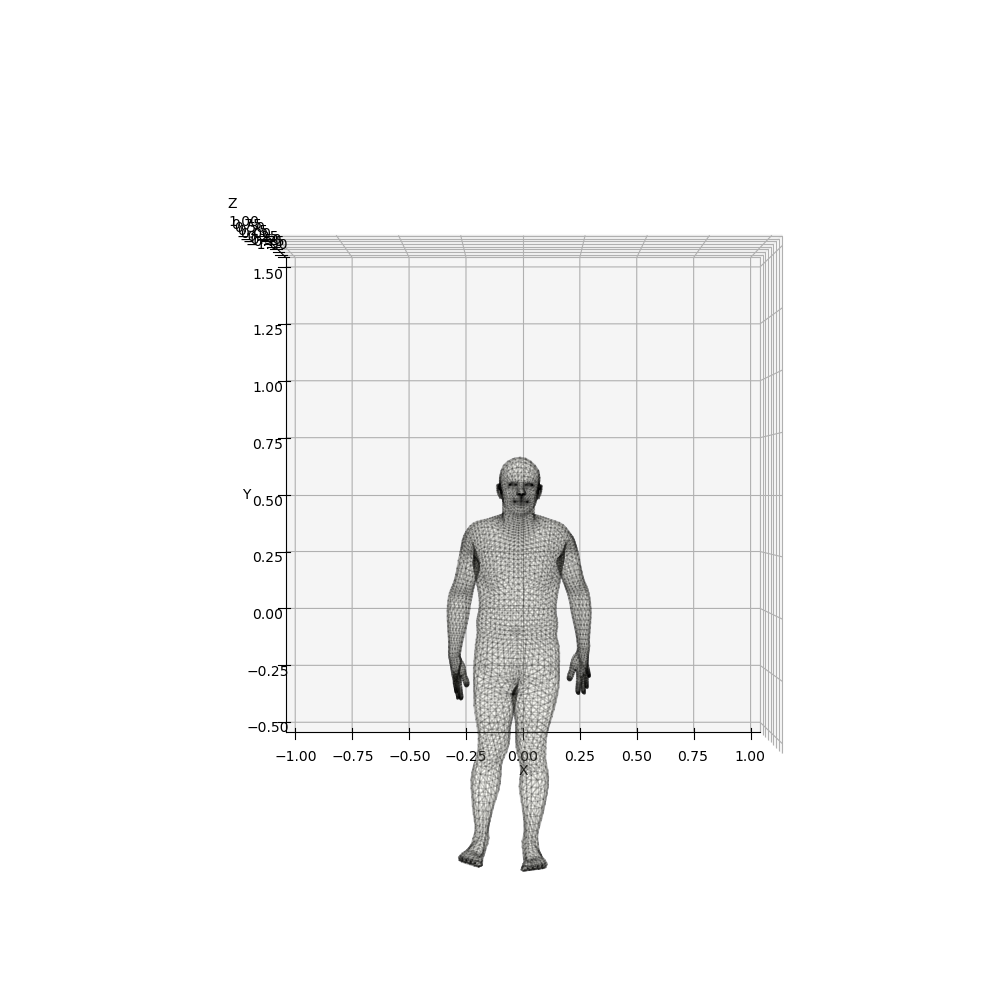

In [91]:
%matplotlib widget
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
def visualize(vertices,joints, human_model):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-0.5, 1.5)  
    ax.set_zlim(-1, 1)
    ax.view_init(elev=90., azim=-90., roll = 0)
    mesh = Poly3DCollection(vertices[human_model.faces], alpha=0.1)
    face_color = (1.0, 1.0, 0.9)
    edge_color = (0, 0, 0)
    mesh.set_edgecolor(edge_color)
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    joints = joints[:24, :]
    ax.scatter(joints[:, 0], joints[:, 1], joints[:, 2], alpha=1, marker='o', color='r', s=10)
    # save fig as np array
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return data

all_frames = []
human_model, _ = init_human_model()
for frame_num in range(0, 250):
    params = get_motion_param(frame_num)
    vertices, joints = update_model(human_model, params)
    all_frames.append(visualize(vertices, human_model))
# save as gif
import imageio
imageio.mimsave(VIZ_OUTPUT/'test.gif', all_frames, fps=30)



# Generate GIF

In [ ]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

# create a list to store all frames
frames = []
max_frames = 60
if max_frames > len(joint_locs):
    raise Exception(f'Reached maximum frame. Try less')
for i in range(max_frames):
    # get one frame
    joint_loc = joint_locs[i, :, :]
    joint_rot = joint_rots[i, :, :]
    
    # convert the list of joint positions to a numpy array
    joint_loc = np.array(joint_loc)
    
    # plot the skeleton
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=0, azim=-55, roll = 0)
    ax.set_xlim(-0.5, 0.2)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(0, 1.4)
    # ax.set_zlim(-0.5, 0.5)
    for i in range(len(joint_loc)):
        # get the parent index
        parent_index = parents[i]
        # plot a line between the current joint and its parent
        if parent_index != -1:
            ax.plot([joint_loc[i, 0], joint_loc[parent_index, 0]],
                    [joint_loc[i, 1], joint_loc[parent_index, 1]],
                    [joint_loc[i, 2], joint_loc[parent_index, 2]], c='r')
        # plot the current joint
        ax.scatter(joint_loc[i, 0], joint_loc[i, 1], joint_loc[i, 2], c='r', marker='o')
        ax.text(joint_loc[i, 0] + 0.02, joint_loc[i, 1], joint_loc[i, 2], f"{i}:{joint_names[i]}", fontsize=10)
        # plot the orientation of the current joint

        ax.quiver(joint_loc[i, 0], joint_loc[i, 1], joint_loc[i, 2],joint_rot[i, 0], joint_rot[i, 1], joint_rot[i, 2], length=0.001, color='b')
    
    # save the current frame
    fig.canvas.draw()
    img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
    frames.append(img)
    
    # close the figure to avoid memory leak
    plt.close(fig)

# save all frames as a gif
frames[0].save(VIZ_OUTPUT / f'joint_view2_{trial_number}.gif', format='GIF', append_images=frames[1:], save_all=True, duration=100, loop=0)

/tmp/ipykernel_3781622/3675222755.py:43: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())


No such comm: 3206be324f2143c9bdc795a748290ce9
No such comm: 3206be324f2143c9bdc795a748290ce9
No such comm: 3206be324f2143c9bdc795a748290ce9
No such comm: 3206be324f2143c9bdc795a748290ce9
No such comm: 3206be324f2143c9bdc795a748290ce9
No such comm: 3206be324f2143c9bdc795a748290ce9
No such comm: f0ae96f3b5924fac8292536016258706
No such comm: f0ae96f3b5924fac8292536016258706
No such comm: f0ae96f3b5924fac8292536016258706
No such comm: f0ae96f3b5924fac8292536016258706
No such comm: f0ae96f3b5924fac8292536016258706
No such comm: f0ae96f3b5924fac8292536016258706
No such comm: cf0946b52d6e4a7aa1b4d271a89b8e5d
No such comm: cf0946b52d6e4a7aa1b4d271a89b8e5d
No such comm: cf0946b52d6e4a7aa1b4d271a89b8e5d
No such comm: cf0946b52d6e4a7aa1b4d271a89b8e5d
No such comm: cf0946b52d6e4a7aa1b4d271a89b8e5d
No such comm: cf0946b52d6e4a7aa1b4d271a89b8e5d
No such comm: 047eb33b9c794c2fa25f76bd8d4f60a1
No such comm: 047eb33b9c794c2fa25f76bd8d4f60a1
No such comm: 047eb33b9c794c2fa25f76bd8d4f60a1
No such comm:

# Generate interactive plot

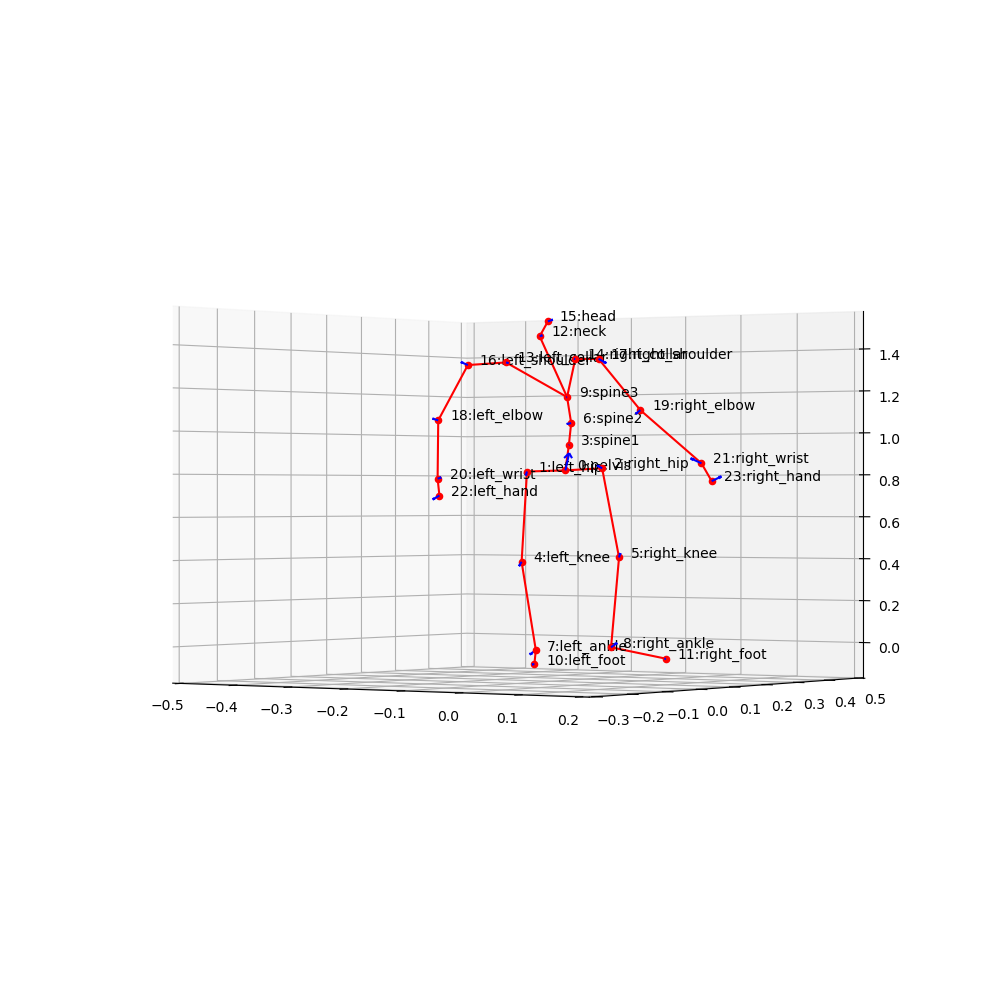

In [ ]:
%matplotlib widget

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

joint_loc = joint_locs[0, :, :]
joint_rot = joint_rots[0, :, :]
# convert the list of joint positions to a numpy array
joint_loc = np.array(joint_loc)
# plot the skeleton
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=0, azim=-55, roll = 0)
ax.set_xlim(-0.5, 0.2)
ax.set_ylim(-0.3, 0.5)
# ax.set_zlim(-0.5, 0.5)
for i in range(len(joint_loc)):
    # get the parent index
    parent_index = parents[i]
    # plot a line between the current joint and its parent
    if parent_index != -1:
        ax.plot([joint_loc[i, 0], joint_loc[parent_index, 0]],
                [joint_loc[i, 1], joint_loc[parent_index, 1]],
                [joint_loc[i, 2], joint_loc[parent_index, 2]], c='r')
    # plot the current joint
    ax.scatter(joint_loc[i, 0], joint_loc[i, 1], joint_loc[i, 2], c='r', marker='o')
    ax.text(joint_loc[i, 0] + 0.02, joint_loc[i, 1], joint_loc[i, 2], f"{i}:{joint_names[i]}", fontsize=10)
    # plot the orientation of the current joint

    ax.quiver(joint_loc[i, 0], joint_loc[i, 1], joint_loc[i, 2],joint_rot[i, 0], joint_rot[i, 1], joint_rot[i, 2], length=0.001, color='b')
fig.savefig(VIZ_OUTPUT / 'joint_sideview_{trial_number}.png', dpi=200)

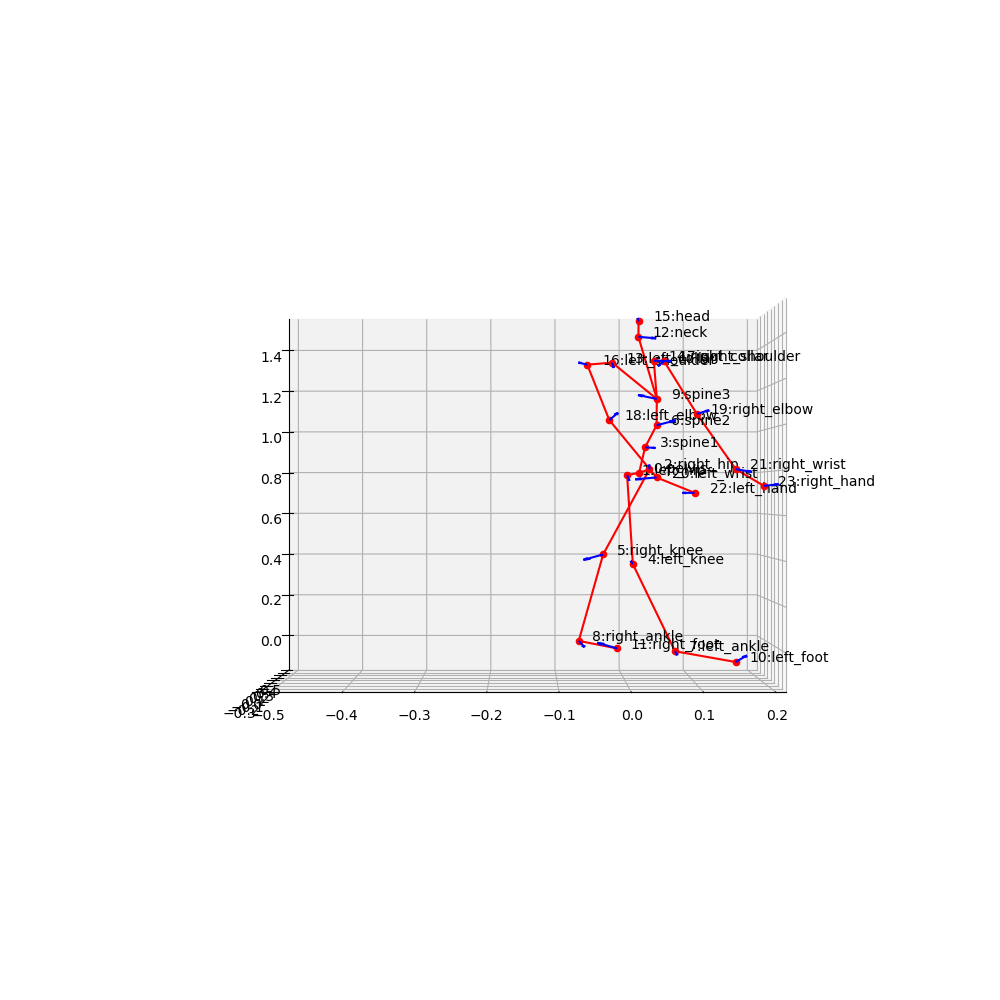

In [ ]:
%matplotlib widget
from rot_convert import euler_to_matrix, matrix_to_euler
# convert the list of joint positions to a numpy array
joint_loc = np.array(joint_loc)
joint_rot = np.array(joint_rot)

# plot the skeleton
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=0, azim=-90, roll = 0)
ax.set_xlim(-0.5, 0.2)
ax.set_ylim(-0.3, 0.5)
# ax.set_zlim(-0.5, 0.5)
for i in range(len(joint_loc)):
    # get the parent index
    parent_index = parents[i]
    # plot a line between the current joint and its parent
    if parent_index != -1:
        ax.plot([joint_loc[i, 0], joint_loc[parent_index, 0]],
                [joint_loc[i, 1], joint_loc[parent_index, 1]],
                [joint_loc[i, 2], joint_loc[parent_index, 2]], c='r')
    # plot the current joint
    ax.scatter(joint_loc[i, 0], joint_loc[i, 1], joint_loc[i, 2], c='r', marker='o')
    ax.text(joint_loc[i, 0] + 0.02, joint_loc[i, 1], joint_loc[i, 2], f"{i}:{joint_names[i]}", fontsize=10)
    # plot the orientation of the current joint given the relative rotation
    if parent_index != -1:
        joint_rot_mat = euler_to_matrix(joint_rot[i])
        parent_rot_mat = euler_to_matrix(joint_rot[parent_index])
        relative_rot = np.matmul(joint_rot_mat, np.linalg.inv(parent_rot_mat))
        relative_rot = matrix_to_euler(relative_rot)
        ax.quiver(joint_loc[i, 0], joint_loc[i, 1], joint_loc[i, 2],
                  relative_rot[0], relative_rot[1], relative_rot[2],
                  length=0.01, color='b')
fig.savefig(VIZ_OUTPUT / 'joint1.png', dpi=200)

## New Dataformat - Captury

In [ ]:
# load csv

import pandas as pd
import numpy as np

import torch
# load csv
csv_path = '/home/siyuan/research/PoseFall/src/utils/bone_rotations.csv'
df = pd.read_csv(csv_path)
df

,Frame,Spine_X,Spine_Y,Spine_Z,Spine1_X,Spine1_Y,Spine1_Z,Spine2_X,Spine2_Y,Spine2_Z,...,RightLeg_Z,RightFoot_X,RightFoot_Y,RightFoot_Z,RightToeBase_X,RightToeBase_Y,RightToeBase_Z,RightFootEE_X,RightFootEE_Y,RightFootEE_Z
0,1,0.002790,0.011661,0.017199,-0.002982,0.023789,0.120250,-0.004925,0.071747,0.058783,...,-0.132340,0.039771,0.141581,-0.016428,-0.000133,-0.003088,-0.231899,1.891749e-09,-4.664714e-12,9.313048e-10
1,2,0.002790,0.011661,0.017199,-0.002982,0.023789,0.120250,-0.004925,0.071747,0.058783,...,-0.132340,0.039771,0.141581,-0.016428,-0.000133,-0.003088,-0.231899,1.891749e-09,-4.664714e-12,9.313048e-10
2,3,0.002182,0.011119,0.017333,-0.003430,0.022370,0.121225,-0.005421,0.067621,0.059160,...,-0.141045,0.040100,0.142686,-0.019297,-0.000134,-0.003072,-0.230716,3.943569e-09,-2.332800e-12,-2.910383e-10
3,4,0.002162,0.011269,0.017373,-0.003537,0.022641,0.121509,-0.005569,0.068454,0.059253,...,-0.135653,0.040524,0.144101,-0.021535,-0.000133,-0.003092,-0.232220,-5.733455e-09,-2.235253e-08,-2.037268e-09
4,5,0.002045,0.011137,0.017619,-0.003608,0.022316,0.123233,-0.005642,0.067501,0.059965,...,-0.135253,0.041042,0.145843,-0.022893,-0.000133,-0.003088,-0.231916,1.818989e-09,-1.490505e-08,1.571589e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,246,0.003582,0.013150,-0.026694,-0.002829,0.027112,-0.187065,-0.004896,0.081631,-0.090905,...,-0.108577,-0.042983,-0.153747,0.296099,0.000489,-0.006253,-0.473976,1.053559e-08,7.520551e-09,-2.037220e-08
246,247,0.003277,0.013154,-0.026549,-0.003206,0.026920,-0.186033,-0.005362,0.081150,-0.091866,...,-0.113046,-0.042544,-0.152012,0.286378,0.000485,-0.006242,-0.473129,1.220906e-08,2.581085e-10,-3.317663e-08
247,248,0.003045,0.013270,-0.026467,-0.003553,0.026987,-0.185446,-0.005804,0.081433,-0.093192,...,-0.119210,-0.041778,-0.149139,0.274255,0.000484,-0.006236,-0.472665,-1.891749e-09,-1.484674e-08,-3.142844e-09
248,249,0.003378,0.013612,-0.026091,-0.003333,0.027848,-0.182837,-0.005569,0.083950,-0.093726,...,-0.135574,-0.040835,-0.145668,0.259591,0.000482,-0.006233,-0.472395,5.529728e-09,-2.215427e-08,-2.326969e-09


In [ ]:
body_joint = df.columns

In [ ]:
new_order = [
    "Spine",
    "LeftUpLeg",
    "RightUpLeg",
    "Spine1",
    "LeftLeg",
    "RightLeg",
    "Spine2",
    "LeftFoot",
    "RightFoot",
    "Spine3",
    "LeftToeBase",
    "RightToeBase",
    "Neck",
    "LeftShoulder",
    "RightShoulder",
    "Head",
    "LeftArm",
    "RightArm",
    "LeftForeArm",
    "RightForeArm",
    "LeftHand",
    "RightHand",
    "LeftHandEE",
    "RightHandEE",

]
SMPL_JOINT_NAMES = [
    "pelvis",
    "left_hip",
    "right_hip",
    "spine1",
    "left_knee",
    "right_knee",
    "spine2",
    "left_ankle",
    "right_ankle",
    "spine3",
    "left_foot",
    "right_foot",
    "neck",
    "left_collar",
    "right_collar",
    "head",
    "left_shoulder",
    "right_shoulder",
    "left_elbow",
    "right_elbow",
    "left_wrist",
    "right_wrist",
    "left_hand",
    "right_hand",
]

In [ ]:
for idx, (new , ref) in enumerate(zip(new_order, SMPL_JOINT_NAMES)):
    print(idx, new, ref)

0 Spine pelvis
1 LeftUpLeg left_hip
2 RightUpLeg right_hip
3 Spine1 spine1
4 LeftLeg left_knee
5 RightLeg right_knee
6 Spine2 spine2
7 LeftFoot left_ankle
8 RightFoot right_ankle
9 Spine3 spine3
10 LeftToeBase left_foot
11 RightToeBase right_foot
12 Neck neck
13 LeftShoulder left_collar
14 RightShoulder right_collar
15 Head head
16 LeftArm left_shoulder
17 RightArm right_shoulder
18 LeftForeArm left_elbow
19 RightForeArm right_elbow
20 LeftHand left_wrist
21 RightHand right_wrist
22 LeftHandEE left_hand
23 RightHandEE right_hand


In [ ]:
# for each new_order, append _x, _y, _z
new_col = []
for i in new_order:
    new_col.append(i + '_X')
    new_col.append(i + '_Y')
    new_col.append(i + '_Z')


In [ ]:
new_col = np.array(new_col, dtype=object)
body_joint = np.array(body_joint)

difference = np.setdiff1d(body_joint, new_col)
redundent = difference[1:]
new_col = np.concatenate(( [difference[0]], new_col, redundent))
df = df[new_col]

In [ ]:
# first frame
joint_rot = df.iloc[0,:][1:].values
joint_rot = joint_rot.reshape(-1, 3)
joint_rot = joint_rot[:23, :]
# convert radian to degree
joint_rot = np.rad2deg(joint_rot)
joint_rot = joint_rot.reshape(-1, 3)


In [ ]:
for idx, (rot, joint_name) in enumerate(zip(joint_rot, SMPL_JOINT_NAMES)):
    print(f"idx: {idx}, {joint_name}: {rot}")



idx: 0, pelvis: [0.15986413 0.6681156  0.98541402]
idx: 1, left_hip: [ -1.62552569 -20.35360343 -13.74906152]
idx: 2, right_hip: [  5.16694035   0.66743435 -16.90801547]
idx: 3, spine1: [-0.17087407  1.36300203  6.88983636]
idx: 4, left_knee: [-5.41966375 10.20959004 -6.57559472]
idx: 5, right_knee: [ 2.75961862  2.32326281 -7.58250206]
idx: 6, spine2: [-0.28217627  4.11080698  3.36801324]
idx: 7, left_ankle: [-2.52388083 -8.95781188 -1.16978622]
idx: 8, right_ankle: [ 2.27869497  8.11199967 -0.94127669]
idx: 9, spine3: [0.198188   0.65797197 5.21575657]
idx: 10, left_foot: [ 0.0095499   0.10875674 -8.18028961]
idx: 11, right_foot: [-7.61357902e-03 -1.76917534e-01 -1.32868549e+01]
idx: 12, neck: [ 0.57005575 -1.51245841 -8.51790586]
idx: 13, left_collar: [-13.22279373   2.3783835    1.6643059 ]
idx: 14, right_collar: [ 2.26568837 -0.00679449  1.93736672]
idx: 15, head: [-0.03194074 -3.23351934 -2.55243529]
idx: 16, left_shoulder: [-4.10808985 49.71706308 71.07515341]
idx: 17, right_sho

In [ ]:
# set all the joint to be zero
joint_rot = np.zeros_like(joint_rot)
print(joint_rot.shape)
joint_rot[17, :] = [0, np.pi//2, 0]


joint_rot=torch.tensor(joint_rot).reshape(1, -1)
joint_rot = joint_rot.float()

(1, 69)


IndexError: index 17 is out of bounds for axis 0 with size 1

In [ ]:
%matplotlib widget
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from pathlib import Path
import smplx, torch


VIZ_OUTPUT = '/home/siyuan/research/PoseFall/src/visulization/viz_output'
VIZ_OUTPUT = Path(VIZ_OUTPUT)

if not VIZ_OUTPUT.is_dir():
    VIZ_OUTPUT.mkdir()

# from smplx.joint_names import  JOINT_NAMES, SMPL_JOINT_NAMES 
model_folder= '/home/siyuan/research/PoseFall/data/SMPL_cleaned'
male_model = "/home/siyuan/research/PoseFall/data/SMPL_cleaned/SMPL_MALE.pkl"

human_model = smplx.SMPL(
    model_path = model_folder,
    create_body_pose=True,
    body_pose= None,
    create_betas=True,
    betas=None,
    gender='male',
)
print(f'joint_rot: {joint_rot.shape}')
output = human_model(body_pose=joint_rot, return_verts=True, return_full_pose=True)
vertices = output.vertices.detach().cpu().numpy()[0]
joints = output.joints.detach().cpu().numpy()
print(f'model faces: {human_model.faces.shape}')
print(f'vertices: {vertices.shape}')

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=90., azim=-90., roll = 0)
mesh = Poly3DCollection(vertices[human_model.faces], alpha=0.1)
face_color = (1.0, 1.0, 0.9)
edge_color = (0, 0, 0)
mesh.set_edgecolor(edge_color)
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)
# ax.scatter(joints[:, 0], joints[:, 1], joints[:, 2], color='r')
joints = joints[:24, :]
print(f'plotting joints: {joints.shape}')
ax.scatter(joints[:, 0], joints[:, 1], joints[:, 2], alpha=1, marker='o', color='r', s=10)
# plt.savefig(output_file, dpi=200)



joint_rot: (1, 69)


TypeError: expected Tensor as element 1 in argument 0, but got numpy.ndarray